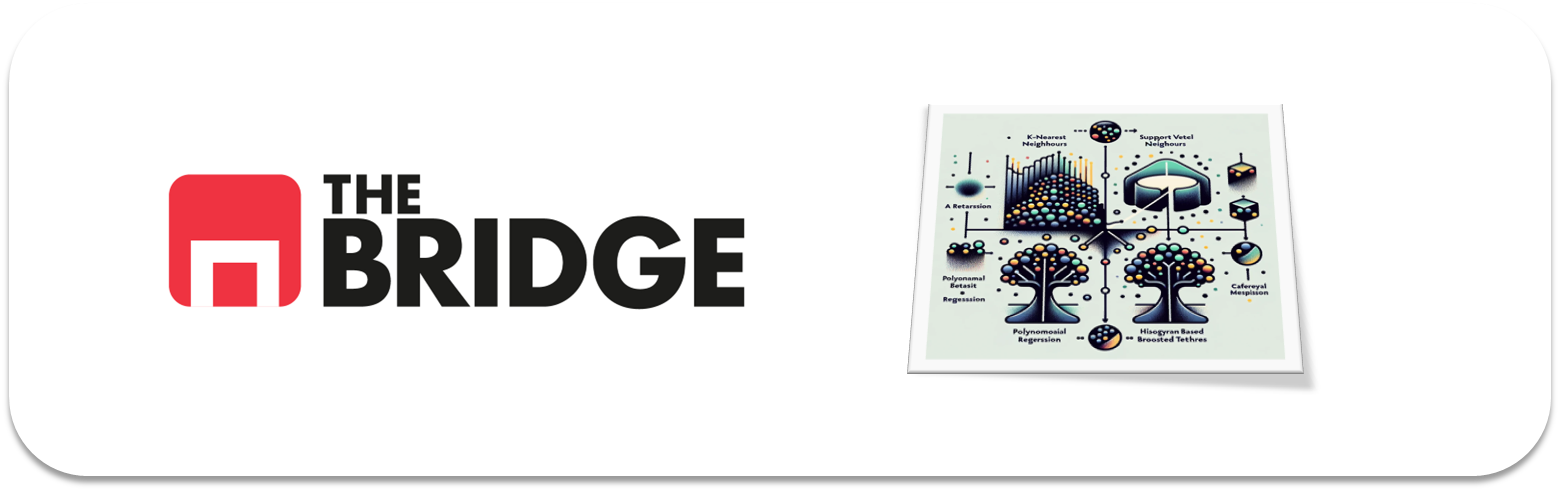

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay,mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor

pd.options.mode.copy_on_write = True

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

In [2]:
df = pd.read_csv("./data/wines_dataset.csv", sep = "|")

In [3]:
df.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
6268,7.8,0.64,0.00,1.9,0.072,27.0,55.0,0.99620,3.31,0.63,11.0,5,red
5332,7.7,0.44,0.24,11.2,0.031,41.0,167.0,0.99480,3.12,0.43,11.3,7,white
404,6.3,0.29,0.40,6.5,0.039,43.0,167.0,0.99530,3.15,0.44,9.3,6,white
476,9.1,0.34,0.42,1.8,0.058,9.0,18.0,0.99392,3.18,0.55,11.4,5,red
6213,10.0,0.23,0.27,14.1,0.033,45.0,166.0,0.99880,2.72,0.43,9.7,6,white


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
target_clf = "quality"
target_reg = "alcohol"

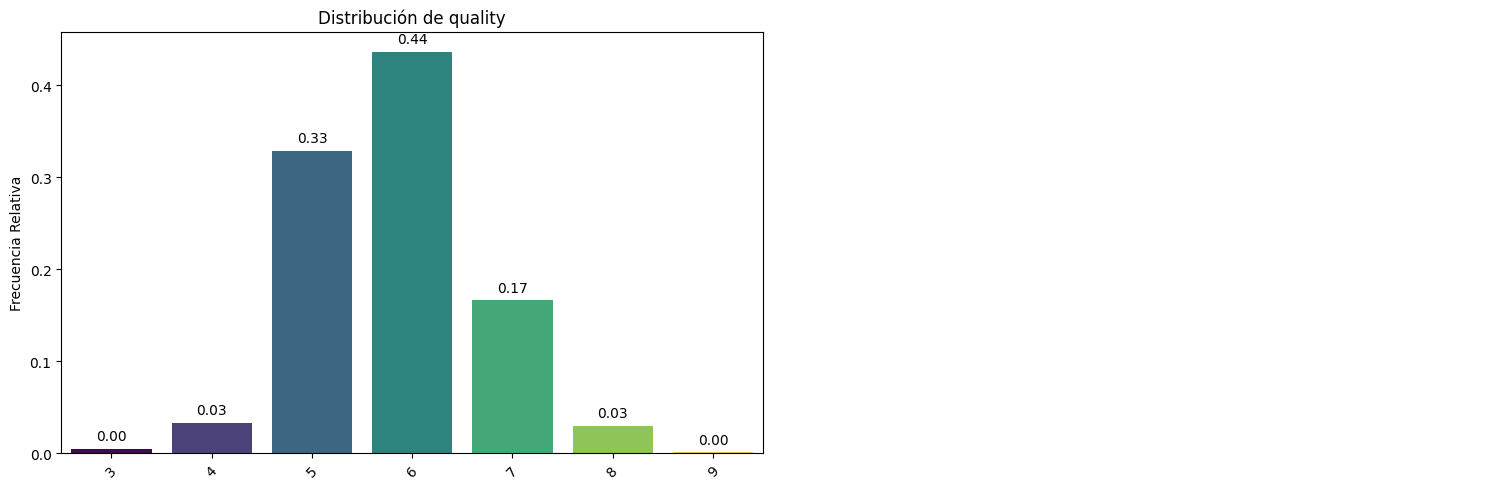

In [6]:
bt.pinta_distribucion_categoricas(df, [target_clf], mostrar_valores = True, relativa = True)

Problema multiclase con gran desbalanceo

<Axes: xlabel='alcohol', ylabel='Count'>

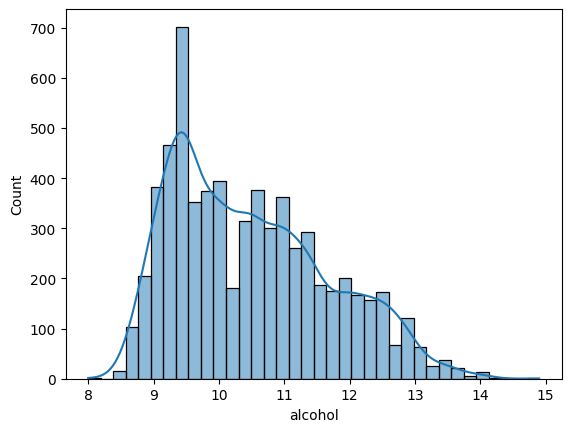

In [7]:
sns.histplot(df[target_reg], kde = True)

No és del todo normal, pero está mal.

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

In [8]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

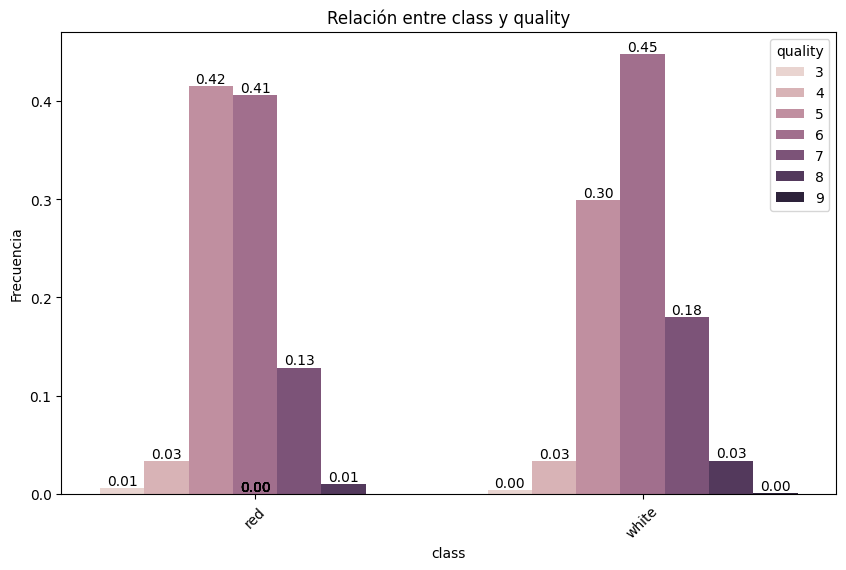

In [9]:
bt.plot_categorical_relationship_fin(train_set, "class", target_clf, show_values= True, relative_freq= True)


5, 6 y 7 parecen más diferenciadas, aunque no tendrá una gran contribución.

In [10]:
feat_cat_clf = ["class"]

In [11]:
feat_num_clf = [col for col in train_set.columns if col != "class" and col != target_clf]

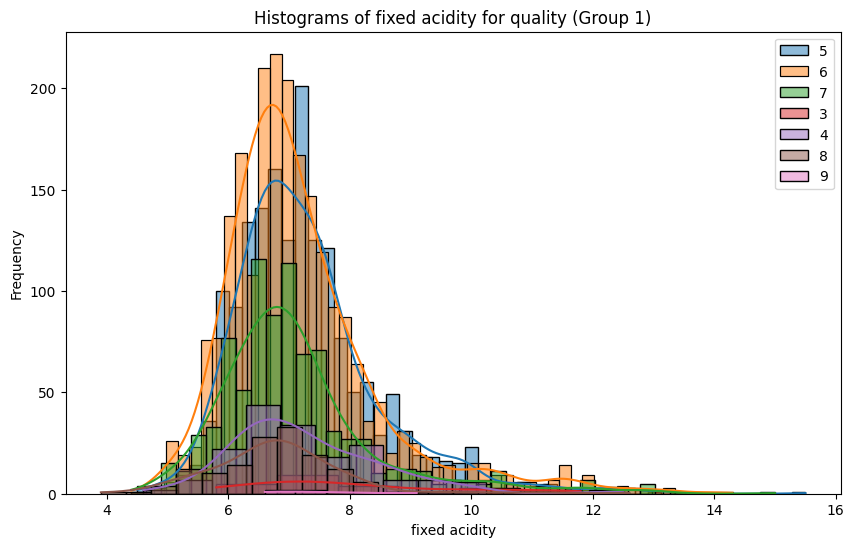

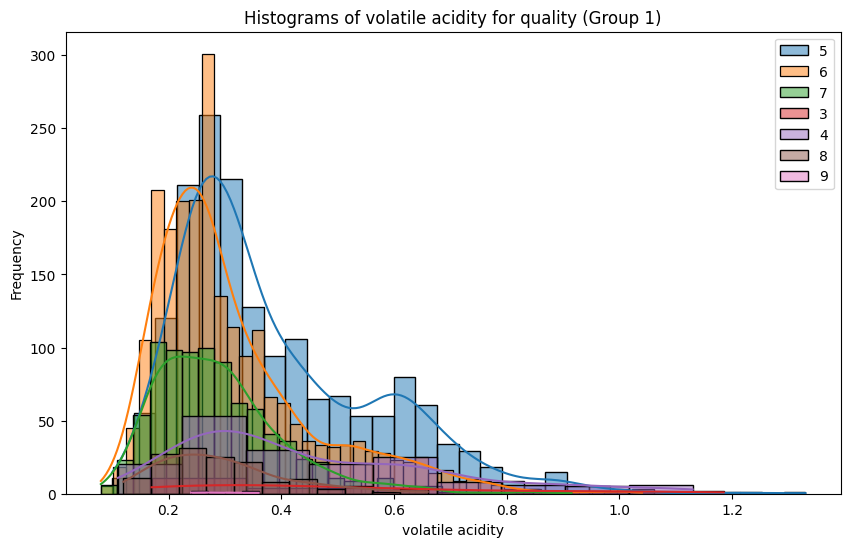

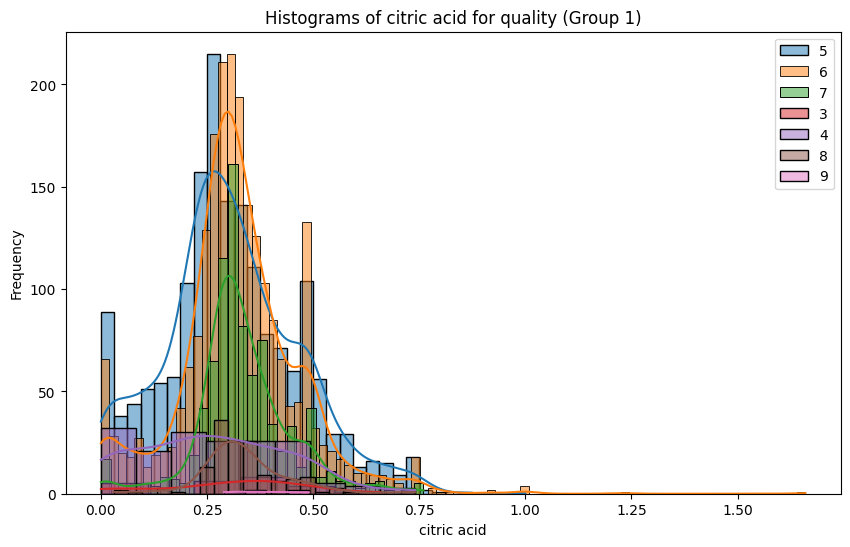

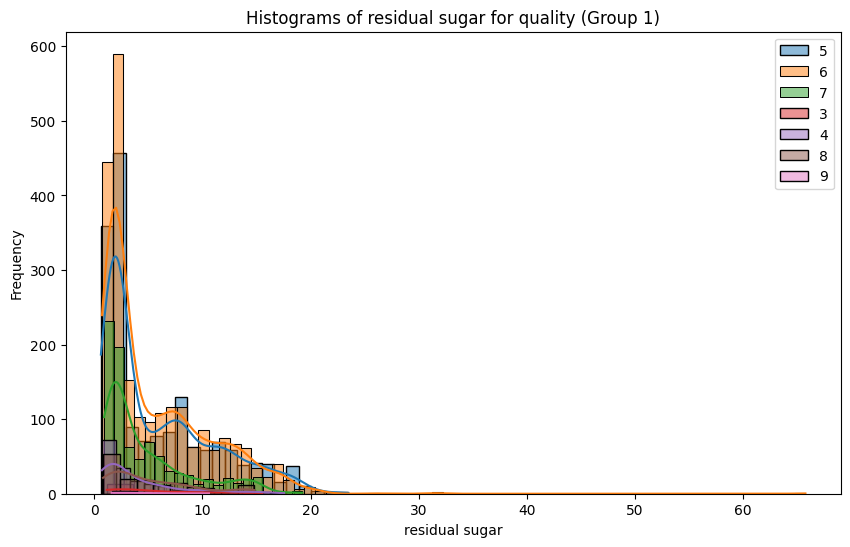

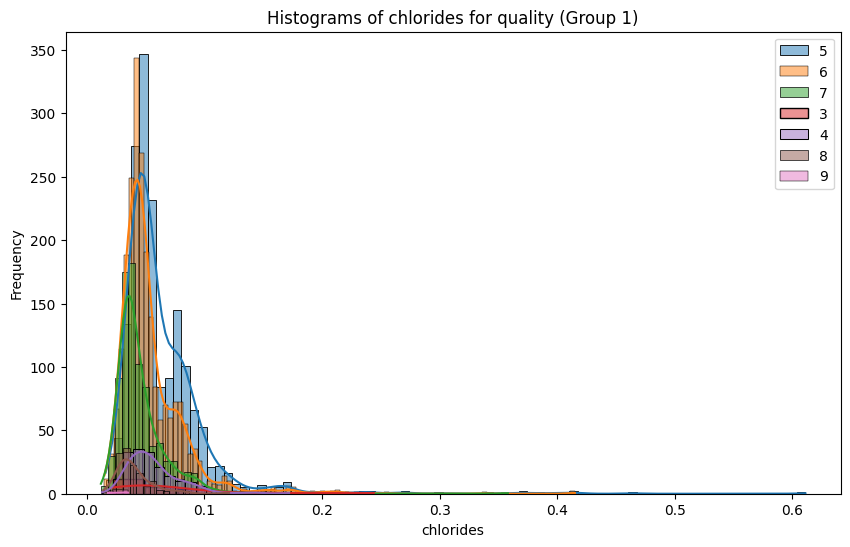

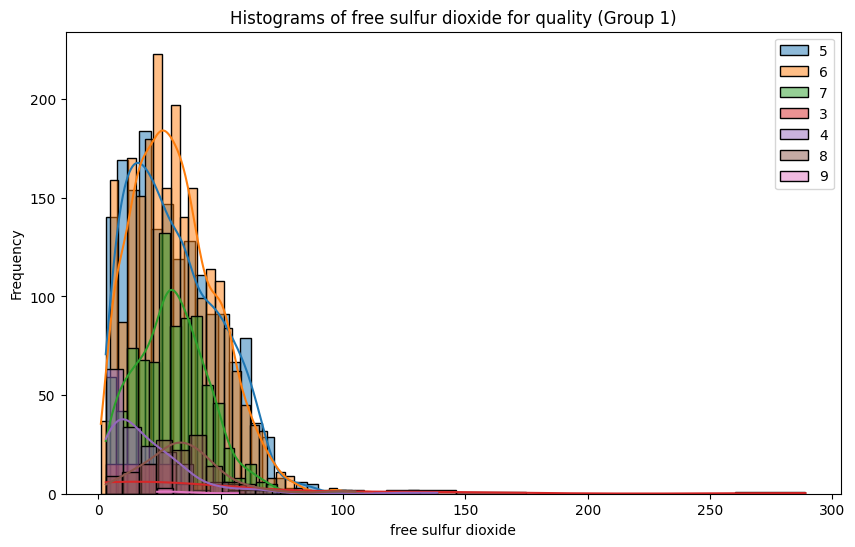

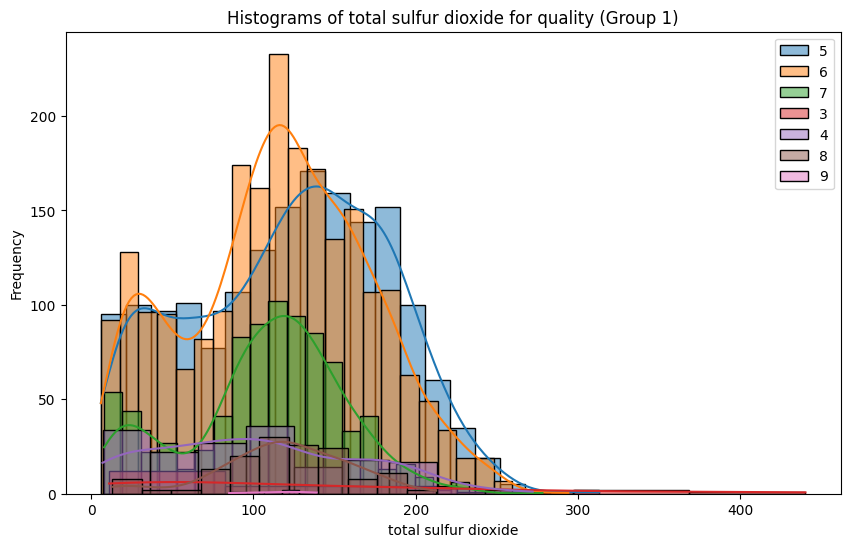

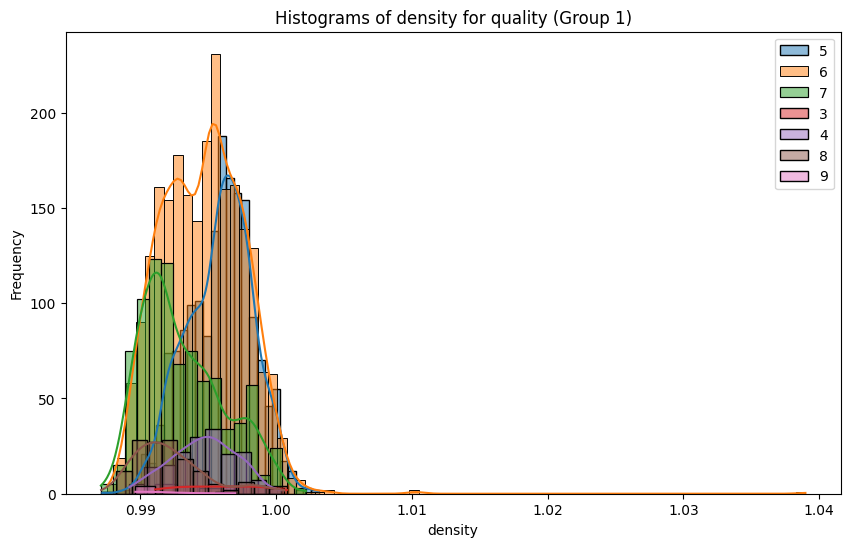

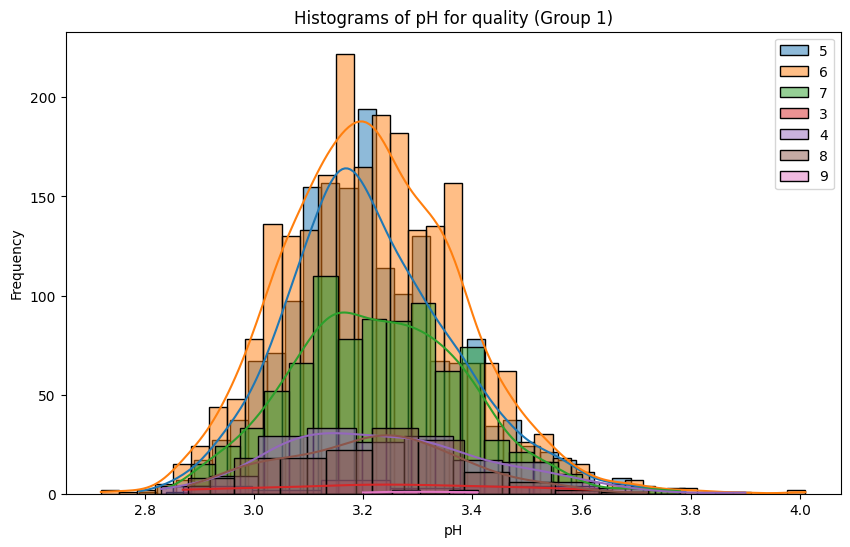

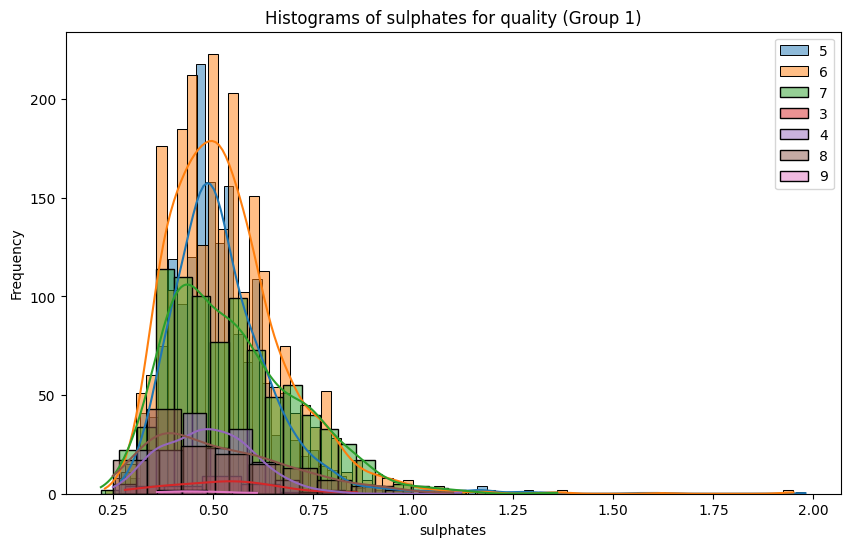

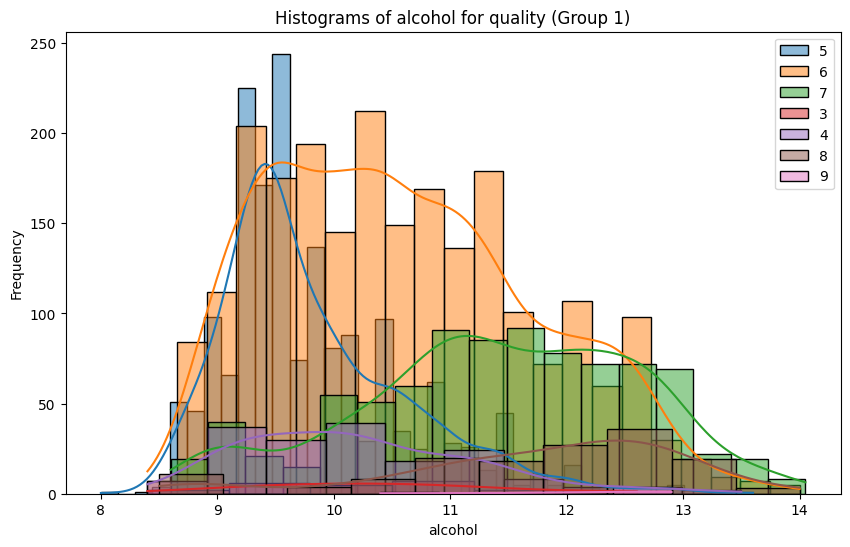

In [12]:
for col in feat_num_clf:
    bt.plot_grouped_histograms(train_set, cat_col= target_clf, num_col= col, group_size= train_set[target_clf].nunique())

Hay unas cuantas variables en las que observamos desplazamiento de las curvas, cruces entre lineas y separación. Nos quedaremos como variables claras chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density y alcohol. Otras menos claras son volatile_acidity, citric_acid, pH y sulphates.

In [13]:
set_num_clf_1 = ["volatile acidity","citric acid","chlorides","free sulfur dioxide","total sulfur dioxide", "density","sulphates","pH","alcohol"] #Claras + mediocres
set_num_clf_2 = ["chlorides","free sulfur dioxide","total sulfur dioxide", "density","alcohol"] #Claras
excluidas = ["fixed acidity","residual sugar"] #No clara

In [14]:
df.iloc[1916]

fixed acidity             7.9
volatile acidity         0.18
citric acid               0.4
residual sugar            2.2
chlorides               0.049
free sulfur dioxide      38.0
total sulfur dioxide     67.0
density                 0.996
pH                       3.33
sulphates                0.93
alcohol                  11.3
quality                     5
class                     red
Name: 1916, dtype: object

In [15]:
train_set["class"] = pd.get_dummies(train_set["class"], columns="class", drop_first=True, dtype=int)
# red -> 0, white -> 1
test_set["class"] = pd.get_dummies(test_set["class"], columns="class", drop_first=True, dtype=int)

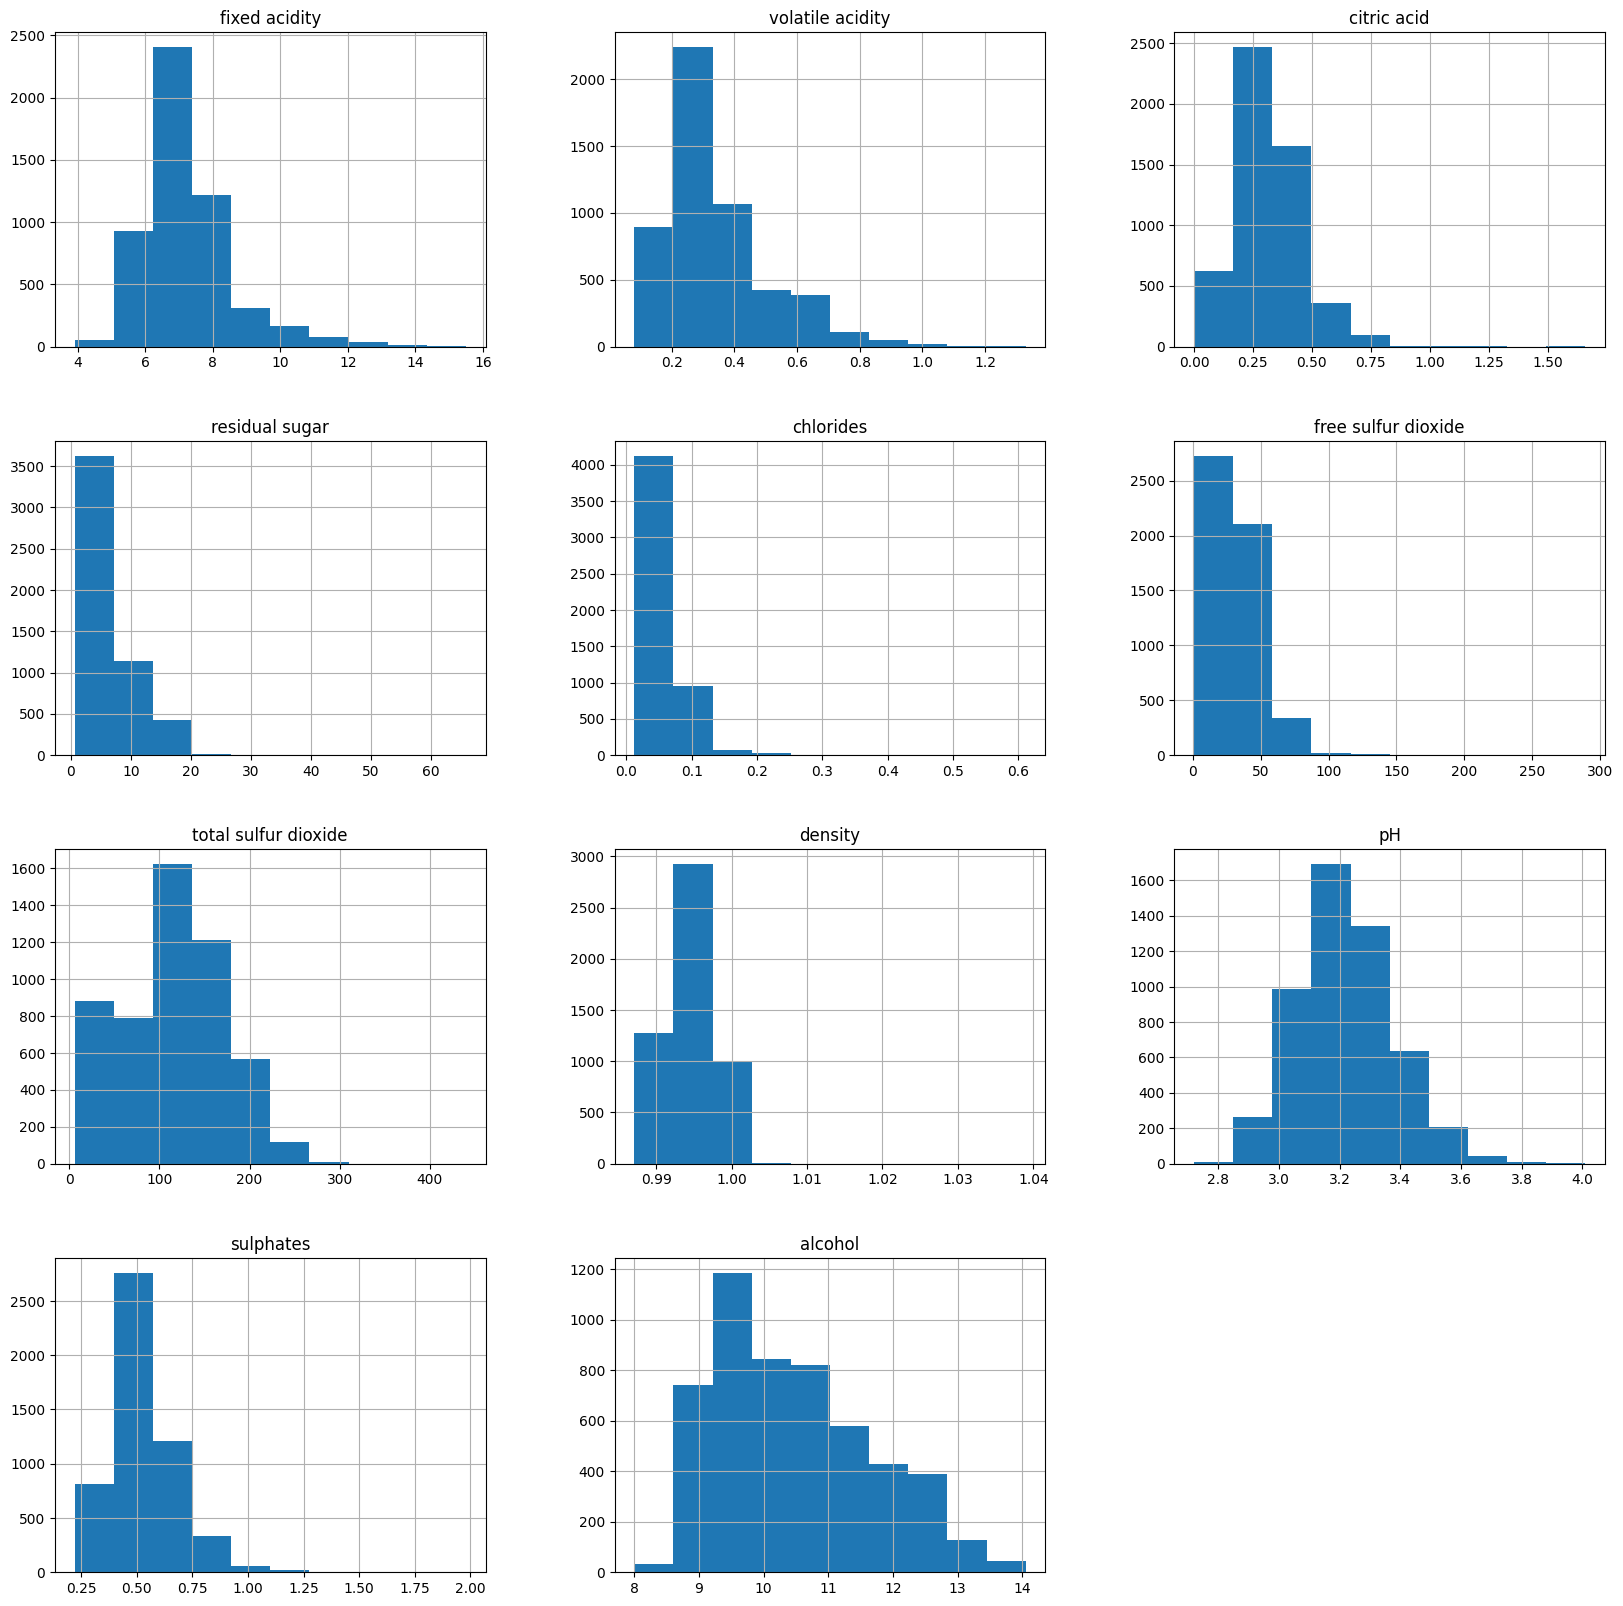

In [16]:
train_set[feat_num_clf].hist(figsize = (20,20))
plt.tight_layout
plt.show()

Todas necesitan normalización excepto density, pH y alcohol.

In [17]:
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

In [18]:
feat_log = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar", 
    "chlorides",
    "free sulfur dioxide", 
    "total sulfur dioxide",
    "sulphates"
]

In [19]:
print(np.isinf(train_set[feat_log]).sum())
print(train_set[feat_log].max())
print(train_set[feat_log].min())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
sulphates               0
dtype: int64
fixed acidity            15.500
volatile acidity          1.330
citric acid               1.660
residual sugar           65.800
chlorides                 0.611
free sulfur dioxide     289.000
total sulfur dioxide    440.000
sulphates                 1.980
dtype: float64
fixed acidity           3.900
volatile acidity        0.080
citric acid             0.000
residual sugar          0.600
chlorides               0.012
free sulfur dioxide     1.000
total sulfur dioxide    6.000
sulphates               0.220
dtype: float64


In [20]:
for col in feat_log:
    if col in ["citric acid"]:
        train_set_scaled[col] = np.log(train_set_scaled[col] + 1)
        test_set_scaled[col] = np.log(test_set_scaled[col] + 1)  
    else:
        train_set_scaled[col] = np.log(train_set_scaled[col])
        test_set_scaled[col] = np.log(test_set_scaled[col]) 

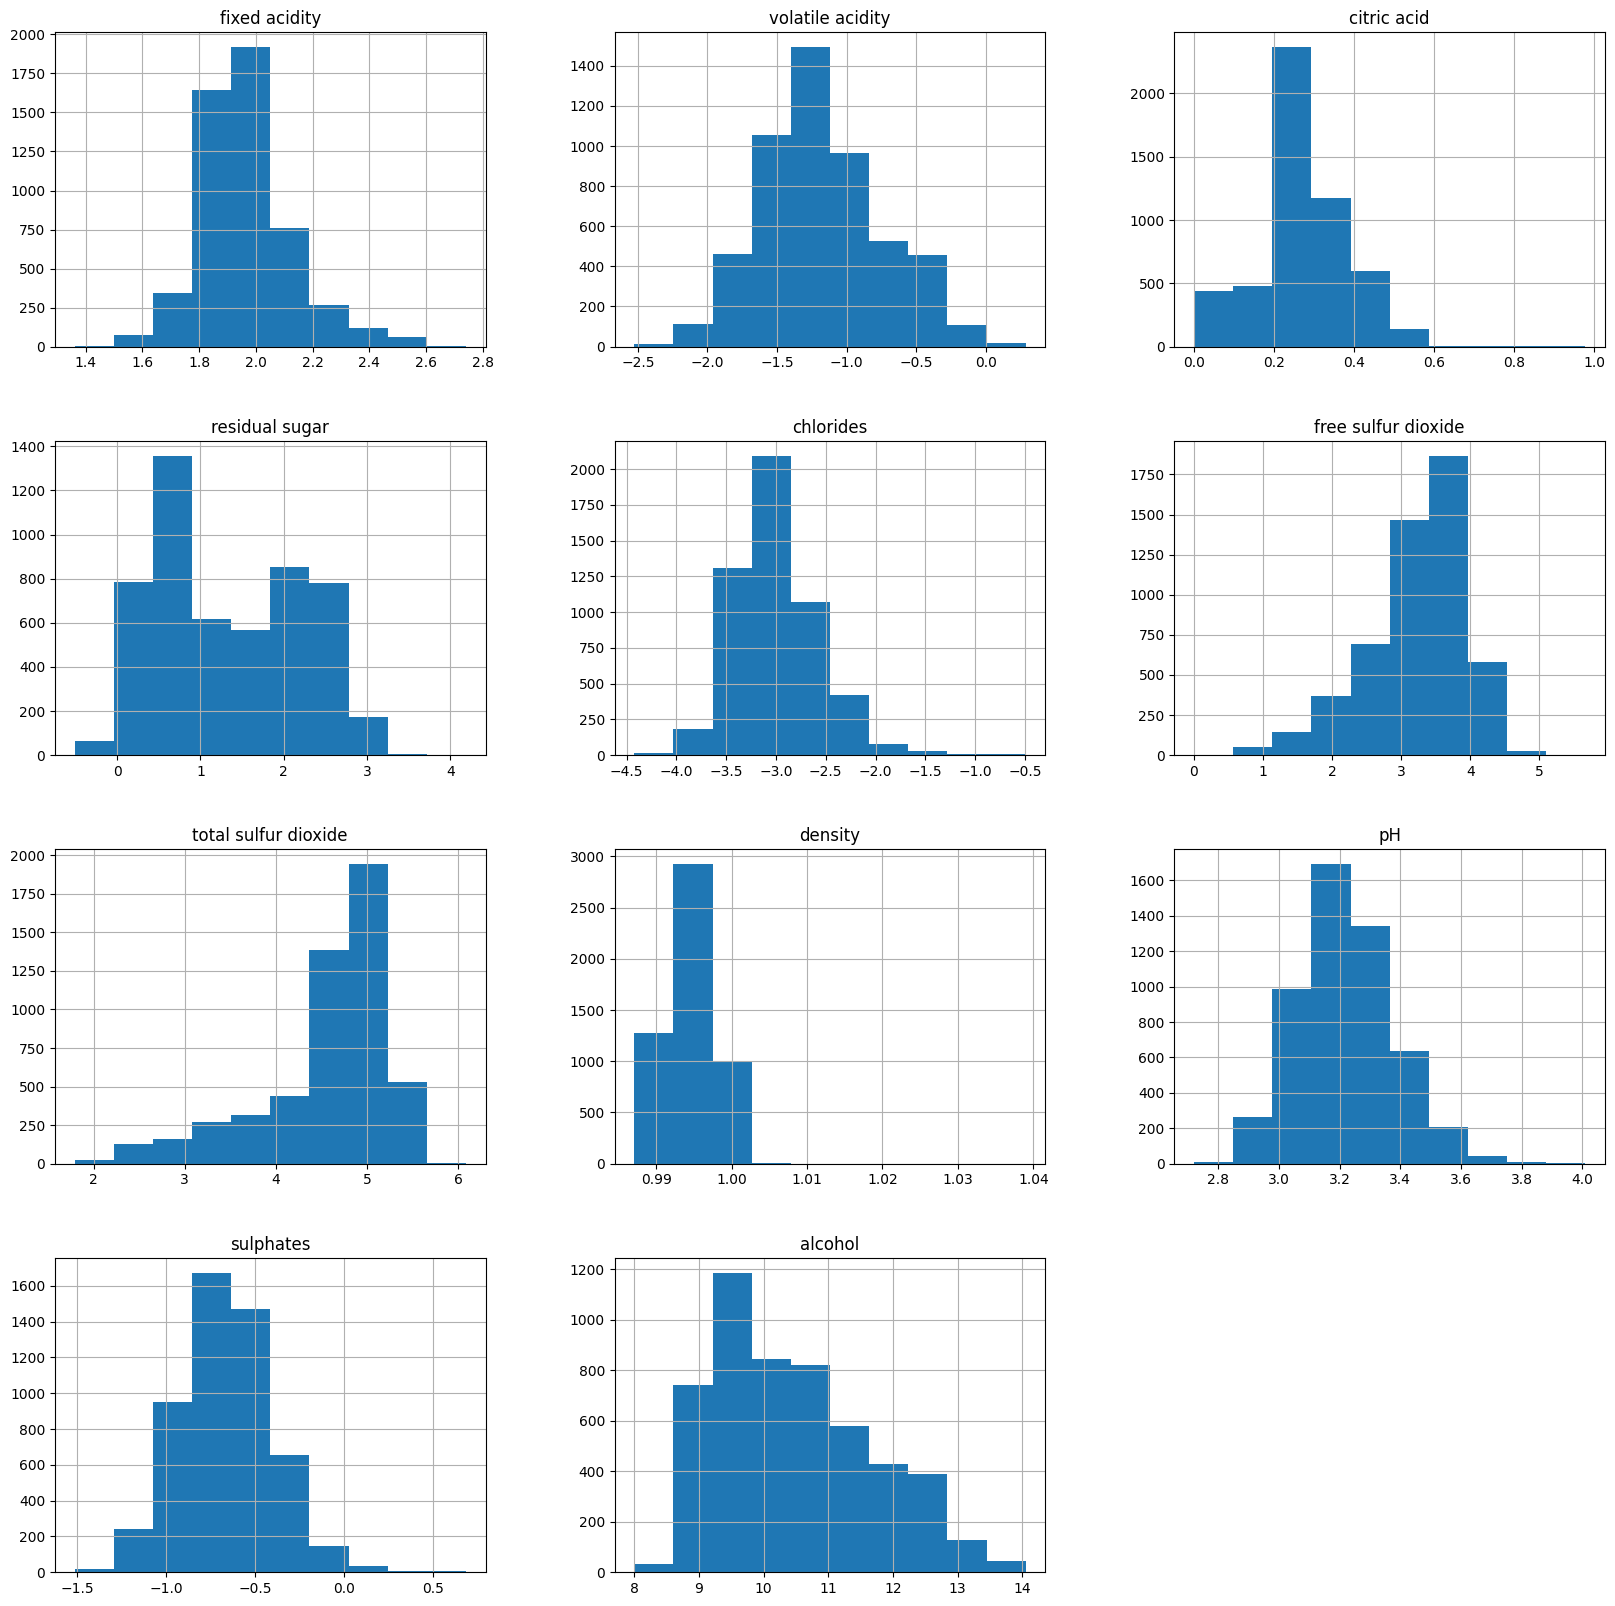

In [21]:
train_set_scaled[feat_num_clf].hist(figsize = (20,20))
plt.tight_layout
plt.show()

In [22]:
scaler = StandardScaler()

train_set_scaled_clf = train_set_scaled.copy()
test_set_scaled_clf = test_set_scaled.copy()

train_set_scaled_clf["alcohol"] = scaler.fit_transform(train_set_scaled_clf[["alcohol"]])
test_set_scaled_clf["alcohol"] = scaler.transform(test_set_scaled_clf[["alcohol"]])

In [23]:
y_train_clf = train_set[target_clf]
y_test_clf = test_set[target_clf]

Probaremos solo con el set de las variables claras por falta de tiempo.

In [36]:
feat_set_clf = feat_cat_clf + set_num_clf_2

X_train_clf = train_set[feat_set_clf]
X_test_clf = test_set[feat_set_clf]
X_train_clf_scaled = train_set_scaled_clf[feat_set_clf]
X_test_clf_scaled = test_set_scaled_clf[feat_set_clf]

In [38]:
knn_clf = KNeighborsClassifier(n_neighbors= 5)
knn_ten_clf = KNeighborsClassifier(n_neighbors= 10)
lr_clf = LogisticRegression(max_iter = 1000)
rf_clf = RandomForestClassifier(max_depth = 6, random_state= 42)
lgb_clf = LGBMClassifier(max_depth = 6, random_state = 42, verbose = -100, n_jobs= -1)

modelos_clf = {
    "KNN_5": knn_clf,
    "KNN_10": knn_ten_clf,
    "Regresion Logistica": lr_clf,
    "Random Forest": rf_clf,
    "LightGBM": lgb_clf
}

In [39]:
resultados = []

for model_nombre, modelo in modelos_clf.items():
    print(f"Para {model_nombre}:", end = " ")
    if model_nombre in ["Regresion Logistica", "KNN"]:
        resultado = np.mean(cross_val_score(modelo, X_train_clf, y_train_clf, cv=5, scoring="balanced_accuracy"))
    else:
        resultado = np.mean(cross_val_score(modelo, X_train_clf_scaled, y_train_clf, cv=5, scoring="balanced_accuracy"))
    print(resultado)
    resultados.append({
        "Modelo": model_nombre,
        "balanced_accuracy": resultado
    })

df_resultados = pd.DataFrame(resultados).sort_values(by="balanced_accuracy", ascending=False).reset_index(drop=True)

ganador = df_resultados.iloc[0]
print(f"\n🏆 GANADOR: {ganador['Modelo']}:(Recall: {ganador['balanced_accuracy']})")

Para KNN_5: 0.2493904913043667
Para KNN_10: 0.22531125721839862
Para Regresion Logistica: 

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

0.20208919295845035
Para Random Forest: 0.21270665863116306
Para LightGBM: 0.29329366654232175

🏆 GANADOR: LightGBM:(Recall: 0.29329366654232175)


Métricas muy pobres por el desbalanceo de clases.

In [45]:
knn_clf = KNeighborsClassifier(n_neighbors= 5, weights= "distance")
knn_ten_clf = KNeighborsClassifier(n_neighbors= 10, weights = "distance")
lr_clf = LogisticRegression(max_iter = 100, class_weight = "balanced")
rf_clf = RandomForestClassifier(max_depth = 6, random_state= 42, class_weight = "balanced")
lgb_clf = LGBMClassifier(max_depth = 6, random_state = 42, verbose = -100, class_weight = "balanced", n_jobs= -1)

modelos_clf = {
    "KNN_5": knn_clf,
    "KNN_10": knn_ten_clf,
    "Regresion Logistica": lr_clf,
    "Random Forest": rf_clf,
    "LightGBM": lgb_clf
}

In [46]:
resultados = []

for model_nombre, modelo in modelos_clf.items():
    print(f"Para {model_nombre}:", end = " ")
    if model_nombre in ["Regresion Logistica", "KNN"]:
        resultado = np.mean(cross_val_score(modelo, X_train_clf, y_train_clf, cv=5, scoring="balanced_accuracy"))
    else:
        resultado = np.mean(cross_val_score(modelo, X_train_clf_scaled, y_train_clf, cv=5, scoring="balanced_accuracy"))
    print(resultado)
    resultados.append({
        "Modelo": model_nombre,
        "balanced_accuracy": resultado
    })

df_resultados = pd.DataFrame(resultados).sort_values(by="balanced_accuracy", ascending=False).reset_index(drop=True)

ganador = df_resultados.iloc[0]
print(f"\n🏆 GANADOR: {ganador['Modelo']}:(Recall: {ganador['balanced_accuracy']})")

Para KNN_5: 0.3260435562904972
Para KNN_10: 0.317203141060446
Para Regresion Logistica: 

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

0.25034943270270665
Para Random Forest: 0.3213587296527188
Para LightGBM: 0.3426091207477192

🏆 GANADOR: LightGBM:(Recall: 0.3426091207477192)


In [48]:
param_grid = {
    "n_estimators": [100,200,1000],
    "max_depth": [1,5,10,20],
    "learning_rate": [0.1,0.3,0.6,1,0.01],
    "class_weight": ["balanced"]
}

lgb_clf = LGBMClassifier(verbose = -1, n_jobs= -1)

lgb_grid = GridSearchCV(lgb_clf,
                        param_grid= param_grid,
                        cv = 5,
                        scoring = "balanced_accuracy")

lgb_grid.fit(X_train_clf, y_train_clf)

GridSearchCV(cv=5, estimator=LGBMClassifier(n_jobs=-1, verbose=-1),
             param_grid={'class_weight': ['balanced'],
                         'learning_rate': [0.1, 0.3, 0.6, 1, 0.01],
                         'max_depth': [1, 5, 10, 20],
                         'n_estimators': [100, 200, 1000]},
             scoring='balanced_accuracy')

In [ ]:
print(lgb_grid.best_params_)
print(lgb_grid.best_score_)

In [49]:
y_pred = lgb_grid.best_estimator_.predict(X_test_clf)
print(classification_report(y_test_clf, y_pred, zero_division= 0.0)) 

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.11      0.33      0.16        43
           5       0.58      0.57      0.58       432
           6       0.59      0.34      0.43       562
           7       0.39      0.62      0.48       210
           8       0.33      0.62      0.43        47

    accuracy                           0.47      1300
   macro avg       0.34      0.41      0.35      1300
weighted avg       0.53      0.47      0.48      1300



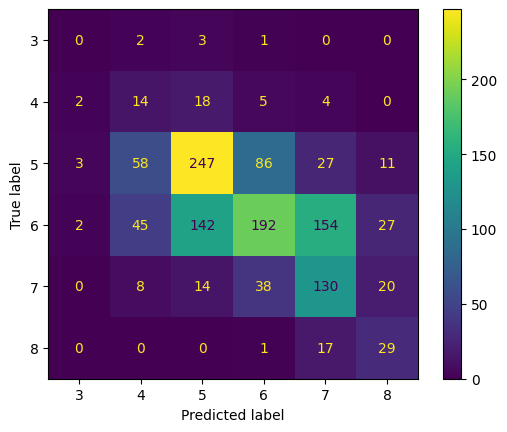

In [50]:
ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred)
plt.show()

### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

In [24]:
feat_cat_reg = ["class", "quality"]

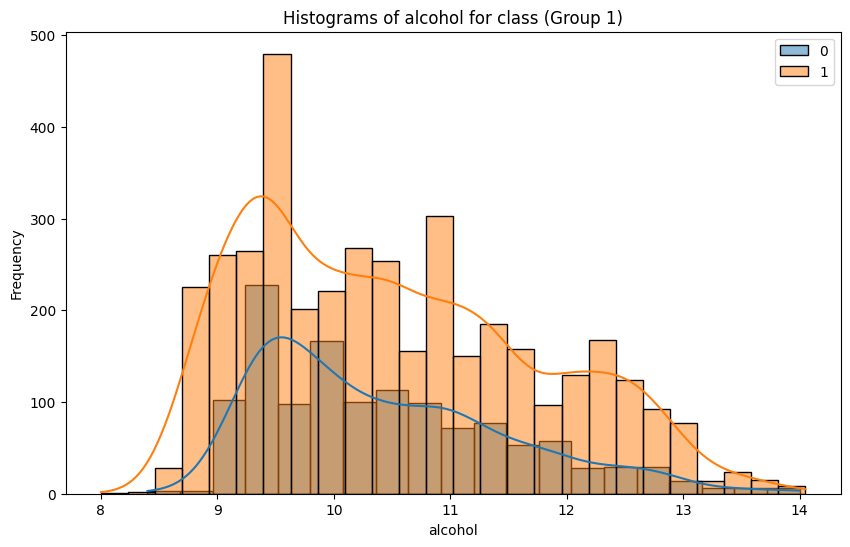

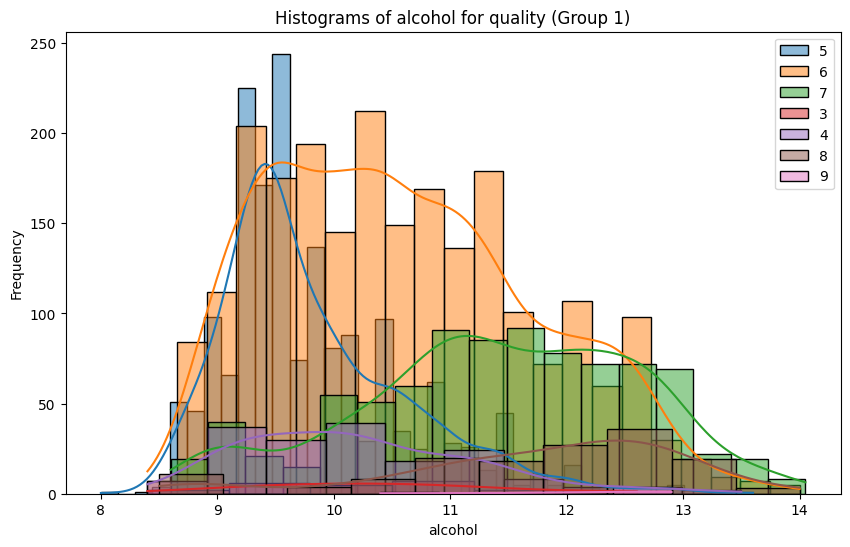

In [25]:
for col in feat_cat_reg:
    bt.plot_grouped_histograms(train_set, cat_col= col, num_col= target_reg, group_size= train_set[col].nunique())

Nos quedamos con quality (ya lo sabíamos antes), pero también añadimos clase.

In [26]:
feat_num_reg = [col for col in train_set.columns if col not in feat_cat_reg]


In [27]:
corr = train_set[feat_num_reg].corr(numeric_only= "True")
serie_corr = np.abs(corr[target_reg]).sort_values(ascending = False)
serie_corr

alcohol                 1.000000
density                 0.682345
residual sugar          0.357459
total sulfur dioxide    0.272970
chlorides               0.260508
free sulfur dioxide     0.188460
pH                      0.116497
fixed acidity           0.091964
volatile acidity        0.036041
citric acid             0.005690
sulphates               0.000412
Name: alcohol, dtype: float64

Nos quedaremos con aquellas con una correlación mayor al 20 %.

In [28]:
r_min = 0.2

feat_num_reg_1 = serie_corr[serie_corr > r_min].index.to_list()
feat_num_reg_1.remove(target_reg)

feat_num_reg_2 = [col for col in train_set.columns if col not in feat_num_reg_1 and col != target_reg
                       and col not in feat_cat_reg]

<Axes: >

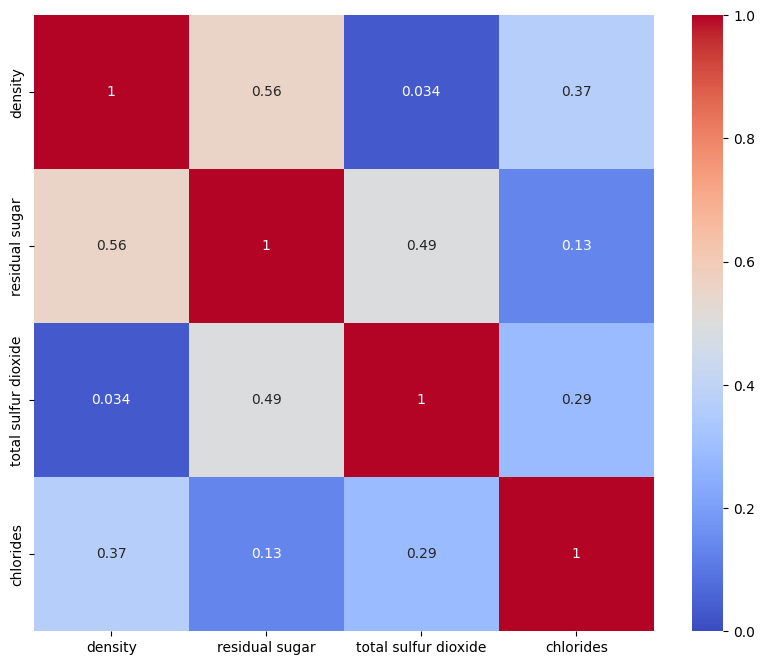

In [29]:
plt.figure(figsize= (10,8))
sns.heatmap(np.abs(train_set[feat_num_reg_1].corr(numeric_only= "True")), annot= True, cmap = "coolwarm", vmin= 0, vmax= 1)

In [30]:
feat_num_reg_2.append("free sulfur dioxide")
feat_num_reg_2.append("pH")

In [31]:
feat_num_reg = feat_num_clf.copy()
feat_num_reg.remove("alcohol") 
feat_num_reg
train_set_scaled[feat_num_reg] = scaler.fit_transform(train_set_scaled[feat_num_reg])
test_set_scaled[feat_num_reg] = scaler.transform(test_set_scaled[feat_num_reg])

In [33]:
y_train_reg = train_set[target_reg]
y_test_reg = test_set[target_reg]

feat_set_reg = feat_cat_reg + feat_num_reg_1

X_train_reg = train_set_scaled[feat_set_reg]
X_test_reg = test_set_scaled[feat_set_reg]